Please upload the Excel files for JPM, GOOG, and NVDA


Saving 1 min data.xlsx to 1 min data.xlsx

ADF Test for JPM_Close:
  p-value: 0.4530
  Test Statistic: -1.6578
  Critical Values: {'1%': np.float64(-3.4412958288564814), '5%': np.float64(-2.8663691131481484), '10%': np.float64(-2.5693418027777777)}

ADF Test for GOOG_Close:
  p-value: 0.3119
  Test Statistic: -1.9435
  Critical Values: {'1%': np.float64(-3.4414632489439714), '5%': np.float64(-2.866442840548375), '10%': np.float64(-2.5693810879206143)}

ADF Test for NVDA_Close:
  p-value: 0.5129
  Test Statistic: -1.5415
  Critical Values: {'1%': np.float64(-3.4415393130846725), '5%': np.float64(-2.866476335860869), '10%': np.float64(-2.5693989358590006)}

ARMA(1,1) Model Summary for JPM_Close:
                               SARIMAX Results                                
Dep. Variable:              JPM_Close   No. Observations:                  601
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 119.754
Date:                Fri, 25 Apr 2025   AIC                 

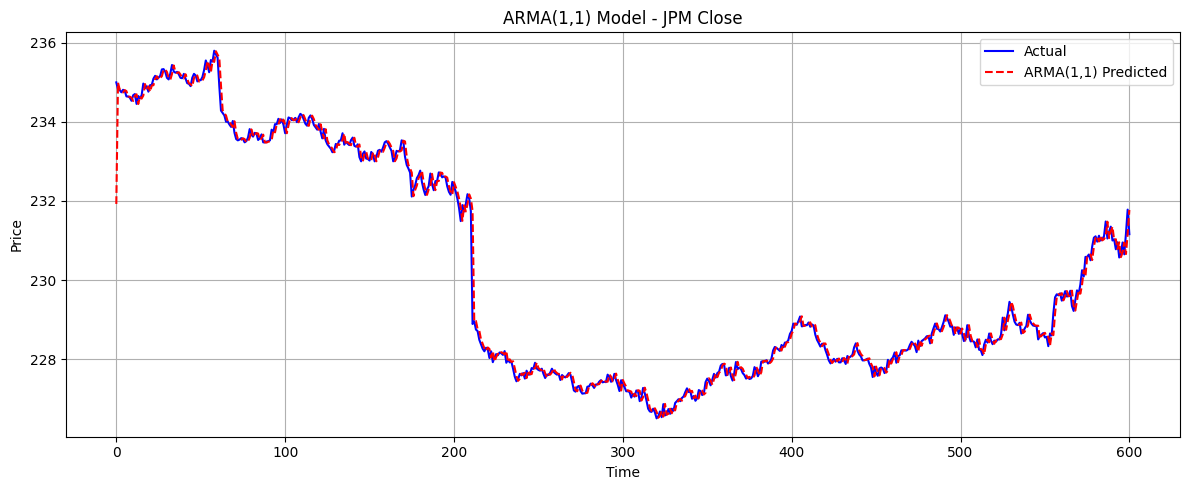

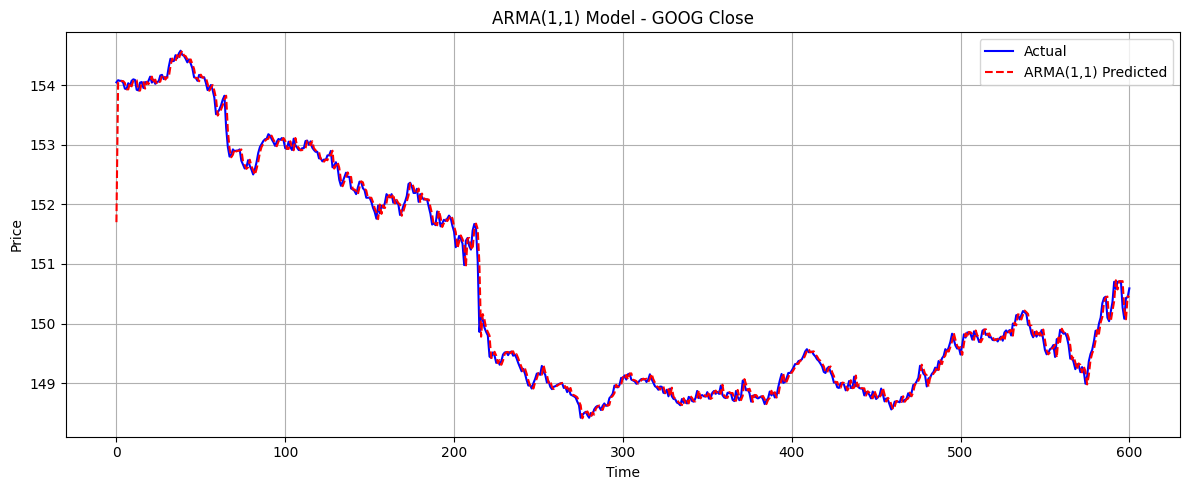

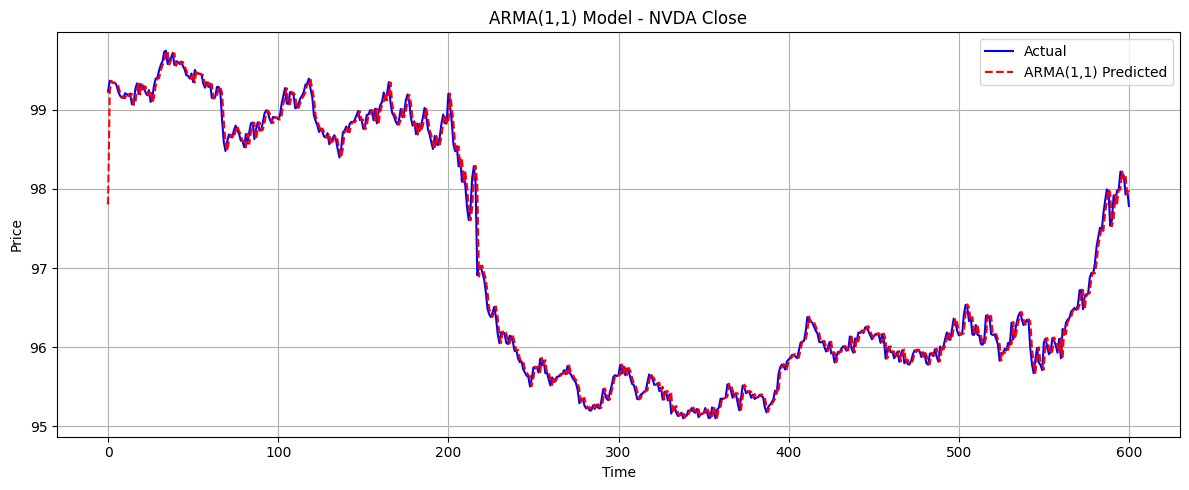


Cointegration Test: JPM ~ GOOG
  p-value: 0.0311

Cointegration Test: JPM ~ NVDA
  p-value: 0.1768

Cointegration Test: GOOG ~ NVDA
  p-value: 0.5508

--- Summary Statistics ---
        JPM_Close  GOOG_Close  NVDA_Close  JPM_Close_Pred  JPM_Close_Resid  \
count  601.000000  601.000000  601.000000      601.000000       601.000000   
mean   230.197653  150.536547   97.037747      230.202922        -0.005270   
std      2.840438    1.884677    1.553660        2.834587         0.233768   
min    226.506000  148.420000   95.100000      226.520821        -2.855766   
25%    227.800000  148.960000   95.760000      227.805672        -0.105665   
50%    228.780400  149.690000   96.195000      228.785289        -0.008951   
75%    233.280000  152.225000   98.805000      233.276428         0.087097   
max    235.795000  154.575000   99.747700      235.781658         3.071910   

       GOOG_Close_Pred  GOOG_Close_Resid  NVDA_Close_Pred  NVDA_Close_Resid  
count       601.000000        601.000000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Interesting Fact ---
The strongest evidence of cointegration is between JPM and GOOG with a p-value of 0.0311, suggesting a potential long-term relationship between these stock prices.


In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from google.colab import files
import io

# Uploading Excel files for JPM, GOOG, and NVDA
print("Please upload the Excel files for JPM, GOOG, and NVDA")
uploaded = files.upload()

# Reading and preparing data from uploaded Excel files
def load_and_clean_data(file_name, close_col):
    try:
        df = pd.read_excel(io.BytesIO(uploaded[file_name]))
        df.columns = df.columns.str.strip()
        # Extracting the closing price column
        df_close = df[[close_col]].dropna()
        # Converting to numeric and handling errors
        df_close = df_close.apply(pd.to_numeric, errors='coerce').dropna()
        return df_close.reset_index(drop=True)
    except Exception as e:
        print(f"Error loading {file_name}: {str(e)}")
        return None

# Loading data for each stock
jpm_data = load_and_clean_data("1 min data.xlsx", "JPM Close")
goog_data = load_and_clean_data("1 min data.xlsx", "GOOG Close")
nvda_data = load_and_clean_data("1 min data.xlsx", "NVDA Close")

# Checking if data was loaded successfully
if jpm_data is None or goog_data is None or nvda_data is None:
    raise ValueError("Failed to load one or more data files. Please check the file format and column names.")

# Combining data into a single DataFrame for analysis
data = pd.concat([jpm_data, goog_data, nvda_data], axis=1)
data.columns = ['JPM_Close', 'GOOG_Close', 'NVDA_Close']
data = data.dropna()

# Performing ADF unit root tests
def perform_adf_test(series, name):
    result = adfuller(series, autolag='AIC')
    print(f"\nADF Test for {name}:")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  Critical Values: {result[4]}")
    return result[1]

adf_results = {}
for col in data.columns:
    adf_results[col] = perform_adf_test(data[col], col)

# Fitting ARMA(1,1) models (ARIMA with d=0)
def fit_arma_model(series, name):
    try:
        model = ARIMA(series, order=(1, 0, 1)).fit()
        print(f"\nARMA(1,1) Model Summary for {name}:")
        print(model.summary())
        return model
    except Exception as e:
        print(f"Error fitting ARMA model for {name}: {str(e)}")
        return None

models = {}
predictions = {}
for col in data.columns:
    models[col] = fit_arma_model(data[col], col)
    if models[col] is not None:
        predictions[col] = models[col].fittedvalues

# Plotting actual vs predicted values
def plot_arma_results(actual, predicted, title):
    plt.figure(figsize=(12, 5))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(predicted, label='ARMA(1,1) Predicted', linestyle='--', color='red')
    plt.title(f'ARMA(1,1) Model - {title}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_arma_plot.png')
    plt.show()

for col in data.columns:
    if col in predictions:
        plot_arma_results(data[col], predictions[col], col.replace('_', ' '))

# Performing cointegration tests
def perform_cointegration_test(series1, series2, name1, name2):
    score, pvalue, _ = coint(series1, series2)
    print(f"\nCointegration Test: {name1} ~ {name2}")
    print(f"  p-value: {pvalue:.4f}")
    return pvalue

cointegration_results = []
pairs = [('JPM_Close', 'GOOG_Close'), ('JPM_Close', 'NVDA_Close'), ('GOOG_Close', 'NVDA_Close')]
for pair in pairs:
    pvalue = perform_cointegration_test(data[pair[0]], data[pair[1]],
                                      pair[0].replace('_Close', ''),
                                      pair[1].replace('_Close', ''))
    cointegration_results.append((pair, pvalue))

# Creating a summary table of predictions and residuals
results_df = data.copy()
for col in data.columns:
    if col in predictions:
        results_df[f'{col}_Pred'] = predictions[col]
        results_df[f'{col}_Resid'] = results_df[col] - results_df[f'{col}_Pred']

# Displaying summary statistics
print("\n--- Summary Statistics ---")
print(results_df.describe())

# Saving results to CSV
results_df.to_csv('arma_cointegration_results.csv')
files.download('arma_cointegration_results.csv')

# Highlighting an interesting fact
print("\n--- Interesting Fact ---")
min_pvalue = min([p for _, p in cointegration_results])
min_pair = [pair for pair, p in cointegration_results if p == min_pvalue][0]
print(f"The strongest evidence of cointegration is between {min_pair[0].replace('_Close', '')} and {min_pair[1].replace('_Close', '')} "
      f"with a p-value of {min_pvalue:.4f}, suggesting a potential long-term relationship between these stock prices.")

Por favor, sube el archivo Excel que contenga las columnas JPM Close, GOOG Close y NVDA Close


Saving 3 min data.xlsx to 3 min data (2).xlsx

Prueba ADF para JPM_Close:
  p-value: 0.4466
  Test Statistic: -1.6701
  Valores Críticos: {'1%': np.float64(-3.4633090972761744), '5%': np.float64(-2.876029332045744), '10%': np.float64(-2.5744932593252643)}

Prueba ADF para GOOG_Close:
  p-value: 0.2979
  Test Statistic: -1.9744
  Valores Críticos: {'1%': np.float64(-3.463476079125), '5%': np.float64(-2.876102355), '10%': np.float64(-2.574532225)}

Prueba ADF para NVDA_Close:
  p-value: 0.5835
  Test Statistic: -1.3975
  Valores Críticos: {'1%': np.float64(-3.463987334463603), '5%': np.float64(-2.8763259091636213), '10%': np.float64(-2.5746515171738515)}

Resumen del modelo ARMA(1,1) para JPM_Close:
                               SARIMAX Results                                
Dep. Variable:              JPM_Close   No. Observations:                  202
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -71.522
Date:                Fri, 25 Apr 2025   AIC             

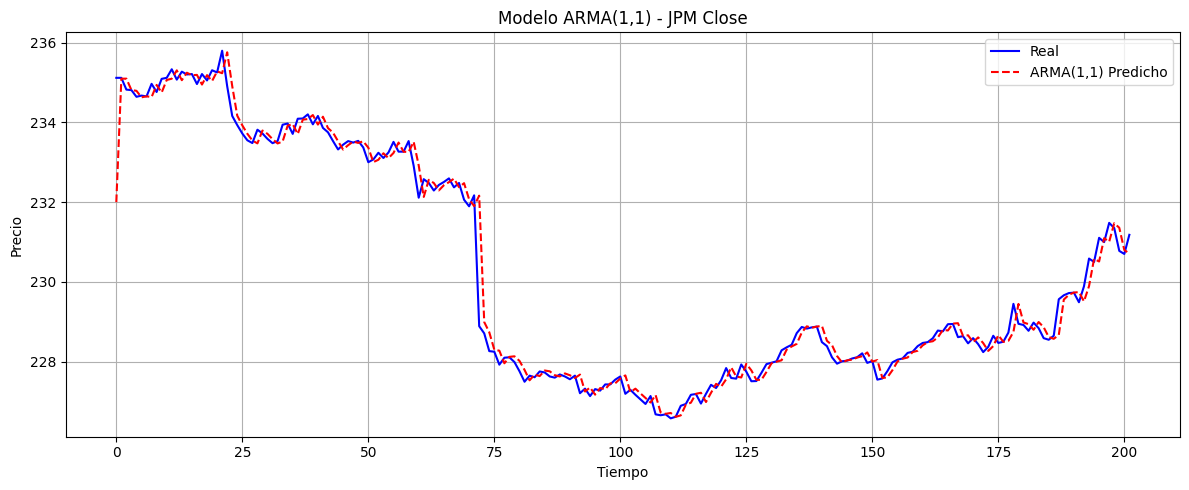

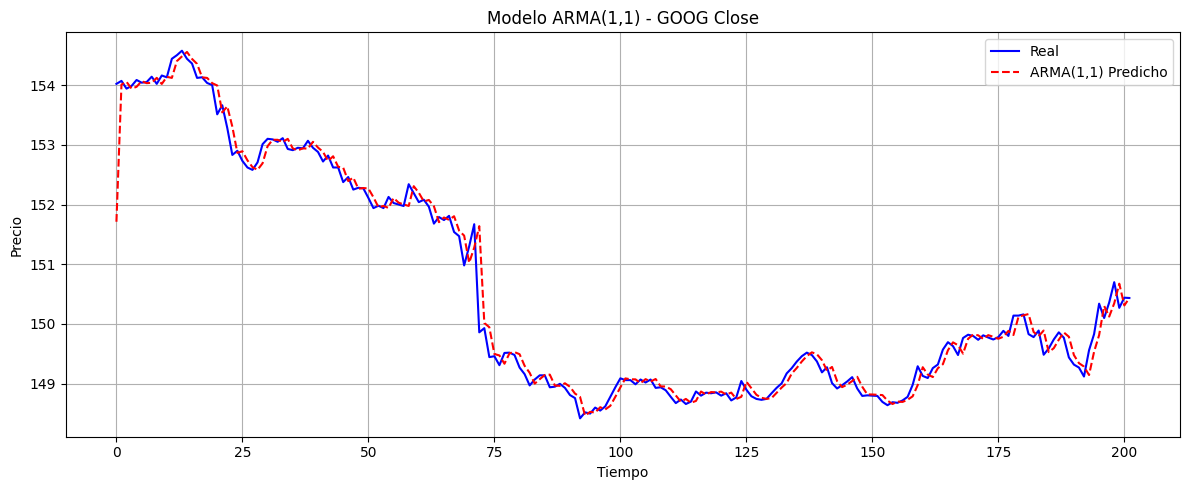

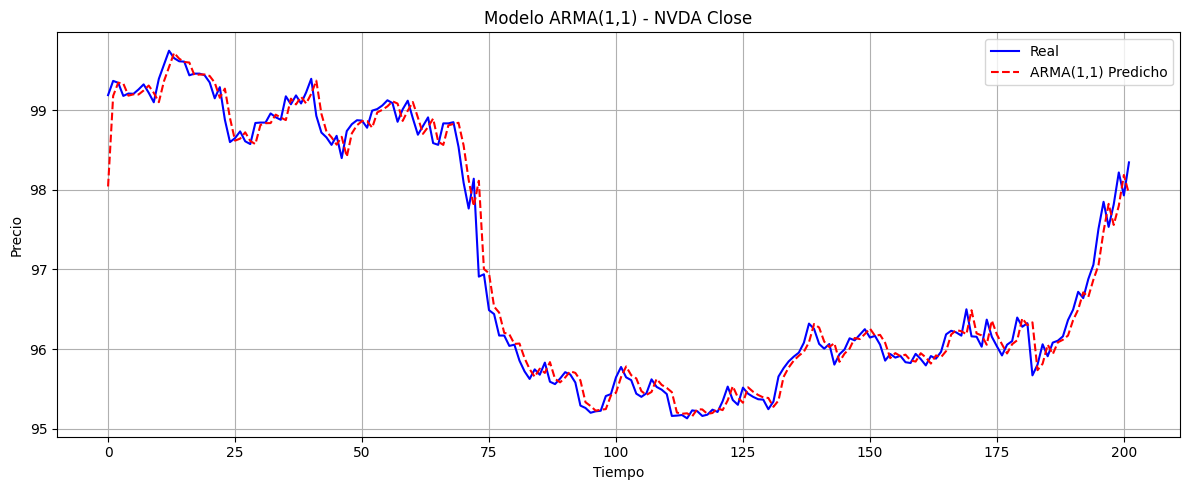


Prueba de cointegración: JPM ~ GOOG
  p-value: 0.2153

Prueba de cointegración: JPM ~ NVDA
  p-value: 0.2138

Prueba de cointegración: GOOG ~ NVDA
  p-value: 0.7387

--- Estadísticas Descriptivas ---
        JPM_Close  GOOG_Close  NVDA_Close  JPM_Close_Pred  JPM_Close_Resid  \
count  202.000000   202.00000  202.000000      202.000000       202.000000   
mean   230.243476   150.54400   97.050392      230.259601        -0.016125   
std      2.876201     1.88934    1.558869        2.859219         0.405379   
min    226.580000   148.42000   95.130000      226.618122        -3.271974   
25%    227.861250   148.97550   95.763750      227.881468        -0.161764   
50%    228.768000   149.71500   96.182250      228.789589        -0.001655   
75%    233.357500   152.23500   98.835000      233.353094         0.117225   
max    235.795000   154.57500   99.747700      235.756211         3.115972   

       GOOG_Close_Pred  GOOG_Close_Resid  NVDA_Close_Pred  NVDA_Close_Resid  
count       202.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Dato Interesante ---
La evidencia más fuerte de cointegración es entre JPM y NVDA, con un p-valor de 0.2138, lo que sugiere una posible relación a largo plazo entre estos precios.


In [38]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from google.colab import files
import io

# Subir el archivo Excel
print("Por favor, sube el archivo Excel que contenga las columnas JPM Close, GOOG Close y NVDA Close")
uploaded = files.upload()

# Obtener el nombre del archivo cargado
file_name = list(uploaded.keys())[0]

# Cargar y preparar los datos desde un único archivo
def load_data_from_single_file(file_name):
    try:
        df = pd.read_excel(io.BytesIO(uploaded[file_name]))
        df.columns = df.columns.str.strip()  # Eliminar espacios en los nombres de columna

        required_cols = ["JPM Close", "GOOG Close", "NVDA Close"]
        for col in required_cols:
            if col not in df.columns:
                raise ValueError(f"La columna '{col}' no está en el archivo.")

        df = df[required_cols].dropna()
        df = df.apply(pd.to_numeric, errors='coerce').dropna()
        df.columns = ['JPM_Close', 'GOOG_Close', 'NVDA_Close']
        return df.reset_index(drop=True)

    except Exception as e:
        print(f"Error al cargar el archivo: {str(e)}")
        return None

# Cargar los datos
data = load_data_from_single_file(file_name)

if data is None:
    raise ValueError("No se pudieron cargar los datos correctamente. Verifica el archivo y los nombres de las columnas.")

# Test de raíz unitaria ADF
def perform_adf_test(series, name):
    result = adfuller(series, autolag='AIC')
    print(f"\nPrueba ADF para {name}:")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  Valores Críticos: {result[4]}")
    return result[1]

adf_results = {}
for col in data.columns:
    adf_results[col] = perform_adf_test(data[col], col)

# Ajustar modelos ARMA(1,1)
def fit_arma_model(series, name):
    try:
        model = ARIMA(series, order=(1, 0, 1)).fit()
        print(f"\nResumen del modelo ARMA(1,1) para {name}:")
        print(model.summary())
        return model
    except Exception as e:
        print(f"Error al ajustar ARMA para {name}: {str(e)}")
        return None

models = {}
predictions = {}
for col in data.columns:
    models[col] = fit_arma_model(data[col], col)
    if models[col] is not None:
        predictions[col] = models[col].fittedvalues

# Graficar resultados reales vs predichos
def plot_arma_results(actual, predicted, title):
    plt.figure(figsize=(12, 5))
    plt.plot(actual, label='Real', color='blue')
    plt.plot(predicted, label='ARMA(1,1) Predicho', linestyle='--', color='red')
    plt.title(f'Modelo ARMA(1,1) - {title}')
    plt.xlabel('Tiempo')
    plt.ylabel('Precio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}_arma_plot.png')
    plt.show()

for col in data.columns:
    if col in predictions:
        plot_arma_results(data[col], predictions[col], col.replace('_', ' '))

# Pruebas de cointegración entre pares
def perform_cointegration_test(series1, series2, name1, name2):
    score, pvalue, _ = coint(series1, series2)
    print(f"\nPrueba de cointegración: {name1} ~ {name2}")
    print(f"  p-value: {pvalue:.4f}")
    return pvalue

cointegration_results = []
pairs = [('JPM_Close', 'GOOG_Close'), ('JPM_Close', 'NVDA_Close'), ('GOOG_Close', 'NVDA_Close')]
for pair in pairs:
    pvalue = perform_cointegration_test(data[pair[0]], data[pair[1]],
                                        pair[0].replace('_Close', ''),
                                        pair[1].replace('_Close', ''))
    cointegration_results.append((pair, pvalue))

# Crear DataFrame con predicciones y residuales
results_df = data.copy()
for col in data.columns:
    if col in predictions:
        results_df[f'{col}_Pred'] = predictions[col]
        results_df[f'{col}_Resid'] = results_df[col] - results_df[f'{col}_Pred']

# Mostrar estadísticas resumen
print("\n--- Estadísticas Descriptivas ---")
print(results_df.describe())

# Guardar resultados a CSV
results_df.to_csv('arma_cointegration_results.csv')
files.download('arma_cointegration_results.csv')

# Dato interesante
print("\n--- Dato Interesante ---")
min_pvalue = min([p for _, p in cointegration_results])
min_pair = [pair for pair, p in cointegration_results if p == min_pvalue][0]
print(f"La evidencia más fuerte de cointegración es entre {min_pair[0].replace('_Close', '')} y {min_pair[1].replace('_Close', '')}, "
      f"con un p-valor de {min_pvalue:.4f}, lo que sugiere una posible relación a largo plazo entre estos precios.")
